In [16]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

list_of_captions = ['Here is a sentence.', 'hello! world.']

# Tokenise a batch of captions
tokens = tokenizer(
  list_of_captions,
  padding="max_length",
  truncation=True,
  max_length=32,
  return_tensors="pt"
)

input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

print("🔢 Input IDs:\n", input_ids)
print("\n🎭 Attention mask:\n", attention_mask)

# 🔍 View token splits and ids
for i, caption in enumerate(list_of_captions):
  print(f"Original: {caption}")
  print("Tokens:", tokenizer.tokenize(caption))
  print("Token IDs:", input_ids[i].tolist())
  print("Decoded:", tokenizer.decode(input_ids[i], skip_special_tokens=True))

print("Other info")
print("Vocab size:", tokenizer.vocab_size)



🔢 Input IDs:
 tensor([[ 101, 2182, 2003, 1037, 6251, 1012,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 7592,  999, 2088, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

🎭 Attention mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
Original: Here is a sentence.
Tokens: ['here', 'is', 'a', 'sentence', '.']
Token IDs: [101, 2182, 2003, 1037, 6251, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: here is a sentence.
Original: hello! world.
Tokens: ['hello', '!', 'world', '.']
To

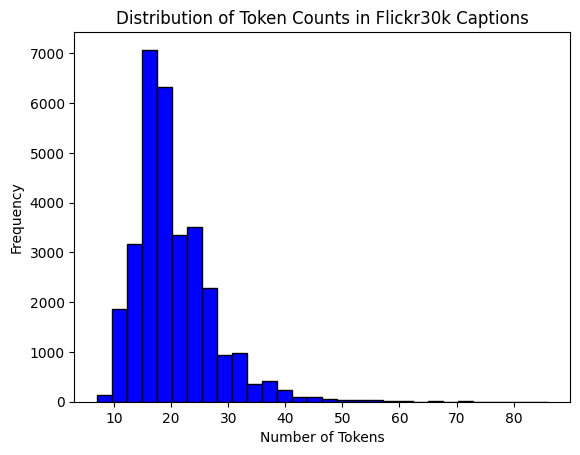

Max token length: 86


In [18]:
# Get max len and distrubtion of flickr captions
metadata_path = Path("/home/bwilliams/mlx/week4/MLX8-W4-Multimodal-TransferLearning/.ben/data/flickr30k/metadata.parquet")
df = pd.read_parquet(metadata_path)

# Tokenize each caption and count tokens
token_lengths = [len(tokenizer.tokenize(caption)) for caption in df["caption"].tolist()]

# Plot histogram
plt.hist(token_lengths, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Token Counts in Flickr30k Captions")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# print max len
print("Max token length:", max(token_lengths))

### Now work on adding embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModel

# 1. Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [23]:
# 2. Grab the embedding layer
embed_layer = model.get_input_embeddings()  
# This is an nn.Embedding of shape (vocab_size, hidden_size)
print("Vocab size:", embed_layer.num_embeddings)
print("Hidden size:", embed_layer.embedding_dim)

# 3. Tokenise some captions
example_data = ["Here is a sentence.", "hello world!"]
tokens = tokenizer(example_data, padding=True, truncation=True, max_length=50, return_tensors="pt")
input_ids = tokens["input_ids"]  # (batch, seq_len)

# 4. Lookup embeddings
embeddings = embed_layer(input_ids)  
# -> Tensor of shape (batch, seq_len, hidden_size)
print("Embeddings shape:", embeddings.shape)
print("Embeddings:", embeddings)




Vocab size: 30522
Hidden size: 768
Embeddings shape: torch.Size([2, 7, 768])
Embeddings: tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0415,  0.0328, -0.0850,  ...,  0.0069,  0.0045,  0.0132],
         [-0.0360, -0.0246, -0.0257,  ...,  0.0034, -0.0018,  0.0269],
         ...,
         [ 0.0321,  0.0063, -0.0064,  ..., -0.0012, -0.1081, -0.0895],
         [-0.0207, -0.0020, -0.0118,  ...,  0.0128,  0.0200,  0.0259],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]],

        [[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0043, -0.0330, -0.0217,  ..., -0.0425, -0.0127, -0.0389],
         [ 0.0244,  0.0322,  0.0024,  ..., -0.0424, -0.0054, -0.0284],
         ...,
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015],
         [-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
         [-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098]]],
       grad_fn=<EmbeddingBa

#### Check some outputs
- CLS is added by bert as it was originally trained on classification tasks, so it would pack a summary of the whole sentence in this token.
- SEP is a separator token, that marks end of sequence
- PAD is pad

In [ ]:
# Print token IDs and their corresponding embeddings
for i, caption in enumerate(example_data):     
    print(f"\nCaption: {caption}")
    token_ids = input_ids[i].tolist()
    token_embeddings = embeddings[i]  # (seq_len, hidden_size)
    
    for token_id, emb in zip(token_ids, token_embeddings):
        token = tokenizer.decode([token_id])
        print(f"Token: {token}, ID: {token_id}, Embedding shape: {emb.shape}")


Caption: Here is a sentence.
Token: [CLS], ID: 101, Embedding shape: torch.Size([768])
Token: here, ID: 2182, Embedding shape: torch.Size([768])
Token: is, ID: 2003, Embedding shape: torch.Size([768])
Token: a, ID: 1037, Embedding shape: torch.Size([768])
Token: sentence, ID: 6251, Embedding shape: torch.Size([768])
Token: ., ID: 1012, Embedding shape: torch.Size([768])
Token: [SEP], ID: 102, Embedding shape: torch.Size([768])

Caption: hello world!
Token: [CLS], ID: 101, Embedding shape: torch.Size([768])
Token: hello, ID: 7592, Embedding shape: torch.Size([768])
Token: world, ID: 2088, Embedding shape: torch.Size([768])
Token: !, ID: 999, Embedding shape: torch.Size([768])
Token: [SEP], ID: 102, Embedding shape: torch.Size([768])
Token: [PAD], ID: 0, Embedding shape: torch.Size([768])
Token: [PAD], ID: 0, Embedding shape: torch.Size([768])
